In [1]:
from src.data.dataset_functions import get_dataframei_onlymods
import pyspark.sql.functions as F

mod_dataframe = get_dataframei_onlymods(4) #Der Parameter steht für den Datensatz, der verwendet werden soll

providing ../data/raw/2022_place_canvas_history-000000000004.csv ...
../data/raw/2022_place_canvas_history-000000000004.csv is already in data/raw
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-696afcc1-8b89-4051-bcbc-9d78330bfe2f;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 79ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------------

<div style="color:#b64365">

* Ich brauche eine Liste mit unterschiedlichen Farben, da Mods recht mit einheitlichen Farben zensiert haben,
    könnte also sonst problematisch werden zu erkennen was zsm.gehört und was nicht 
 
* Ich muss die zwei Koordinaten eines Mods in eine Liste von einzelenen Pixeln umwandeln, damit jeder Pixel gezeichnet wird.
* Oder ich lasse nur den Rahmen und nicht das komplette Quadrat zeichnen, dann könnte es aber vllt. schwierig auf dem Canvas zu erkennen sein?
    -> ich beginge wahrscheinlich erstmal nur mit dem Rahmen und schaue wie gut man das ganze erkennen kann
</div>

<div style="color:#d4597e">

* Im ersten Schritt schmeiße ich erstmal alle Spalten raus die nicht benötigt werden
* Anschließend versuche ich die Liste mit vielen unterschiedlichen Farben zu generieren
* Und danach eine Liste mit Pixeln für die Mods zu erstellen die gezeichnet werden soll

</div>

In [3]:
only_needed_columns = mod_dataframe.drop('t')
only_needed_columns.printSchema()
#Es werden keine Duplikate an Mods entfernt, da ich alle Einträge insgesamt haben will und nicht pro Mod einen

root
 |-- user_id: string (nullable = true)
 |-- x1: integer (nullable = true)
 |-- y1: integer (nullable = true)
 |-- x2: integer (nullable = true)
 |-- y2: integer (nullable = true)
 |-- pixel_color: string (nullable = true)



In [4]:
import random

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
#Der Parameter gibt an wie viele Farben man bekommt
#print(get_colors(5))

['#eab2ef', '#ffb61f', '#b90e05', '#6f17a9', '#17e16c']


In [5]:
#Um für alle Einträge eine Farbe zu bekommen, brauch ich hier nochmal die Anzahl an gemachten Einträgen
amount_of_needed_colors = only_needed_columns.count()

In [6]:
#Entsprechend der Anzahl an Zensuren eine Liste mit der Menge an zufälligen Farben generieren
color_list = get_colors(amount_of_needed_colors)
print(color_list)

['#d231c7', '#81a7e6', '#fb794c']


<div style="color:#d4597e">
Nun die Pixel entsprechend zum Rahmen umwandeln:

* Ich könnte hier einfach ein eigenes DataFrame erstellen, dass ich über eine For-Schleife entsprechend befülle
* Sodass jeder Pixel dort einmal mit seinen x,y - Koordinaten aufgelistet wird für einen Mod und eine der Farben in der Liste
    zugeordnet bekommt
* Danach müsste alles "Problemlos" ins Canvas eingetragen werden können
</div>

In [7]:
import pandas as pd

umwandlung = only_needed_columns.drop('user_id').drop('pixel_color').collect()
index = 0 #Index der besagt welcher Index der Farbliste gneutzt werden soll
pandasM = pd.DataFrame() #Neues DataFrame erstellen, dass befüllt werden soll
pandasM.insert(0,"x", [], True)
pandasM.insert(1,"y", [], True)
pandasM.insert(2,"pixel_color", [], True)
for row in umwandlung:
    color = color_list[index] #Farbe für jeweiliges Quadrat wählen
    x1,y1,x2,y2 = list(row)
    for i in range(x1,x2+1): #zunächst obere Rahmenlinie erstellen
        #df.loc[len(df.index)] = [value1, value2, value3, ...]
        pandasM.loc[len(pandasM.index)] = [i,y1,color]
        #pandasM.loc(i,y1,color)
    for i in range(y1+1,y2+1): #linke Rahmenlinie
        pandasM.loc[len(pandasM.index)] = [x1,i,color]
        #pandasM.loc(x1,i,color)
    for i in range(y1+1,y2+1):
        pandasM.loc[len(pandasM.index)] = [x2,i,color]
        #pandasM.loc(x2,i,color)
    for i in range(x1+1,x2):
        pandasM.loc[len(pandasM.index)] = [i,y2,color]
        #pandasM.loc(i,y2,color)
    index+=1 #nächste Farbe betrachten
#DataFrame sollte mit allen nötigen Daten aufgefüllt worden sein
    

<div style="color:#d4597e">

Jetzt probiere ich mich am Canvas, verwende dafür Gretas Code mit den Bots als Beispiel.

</div>

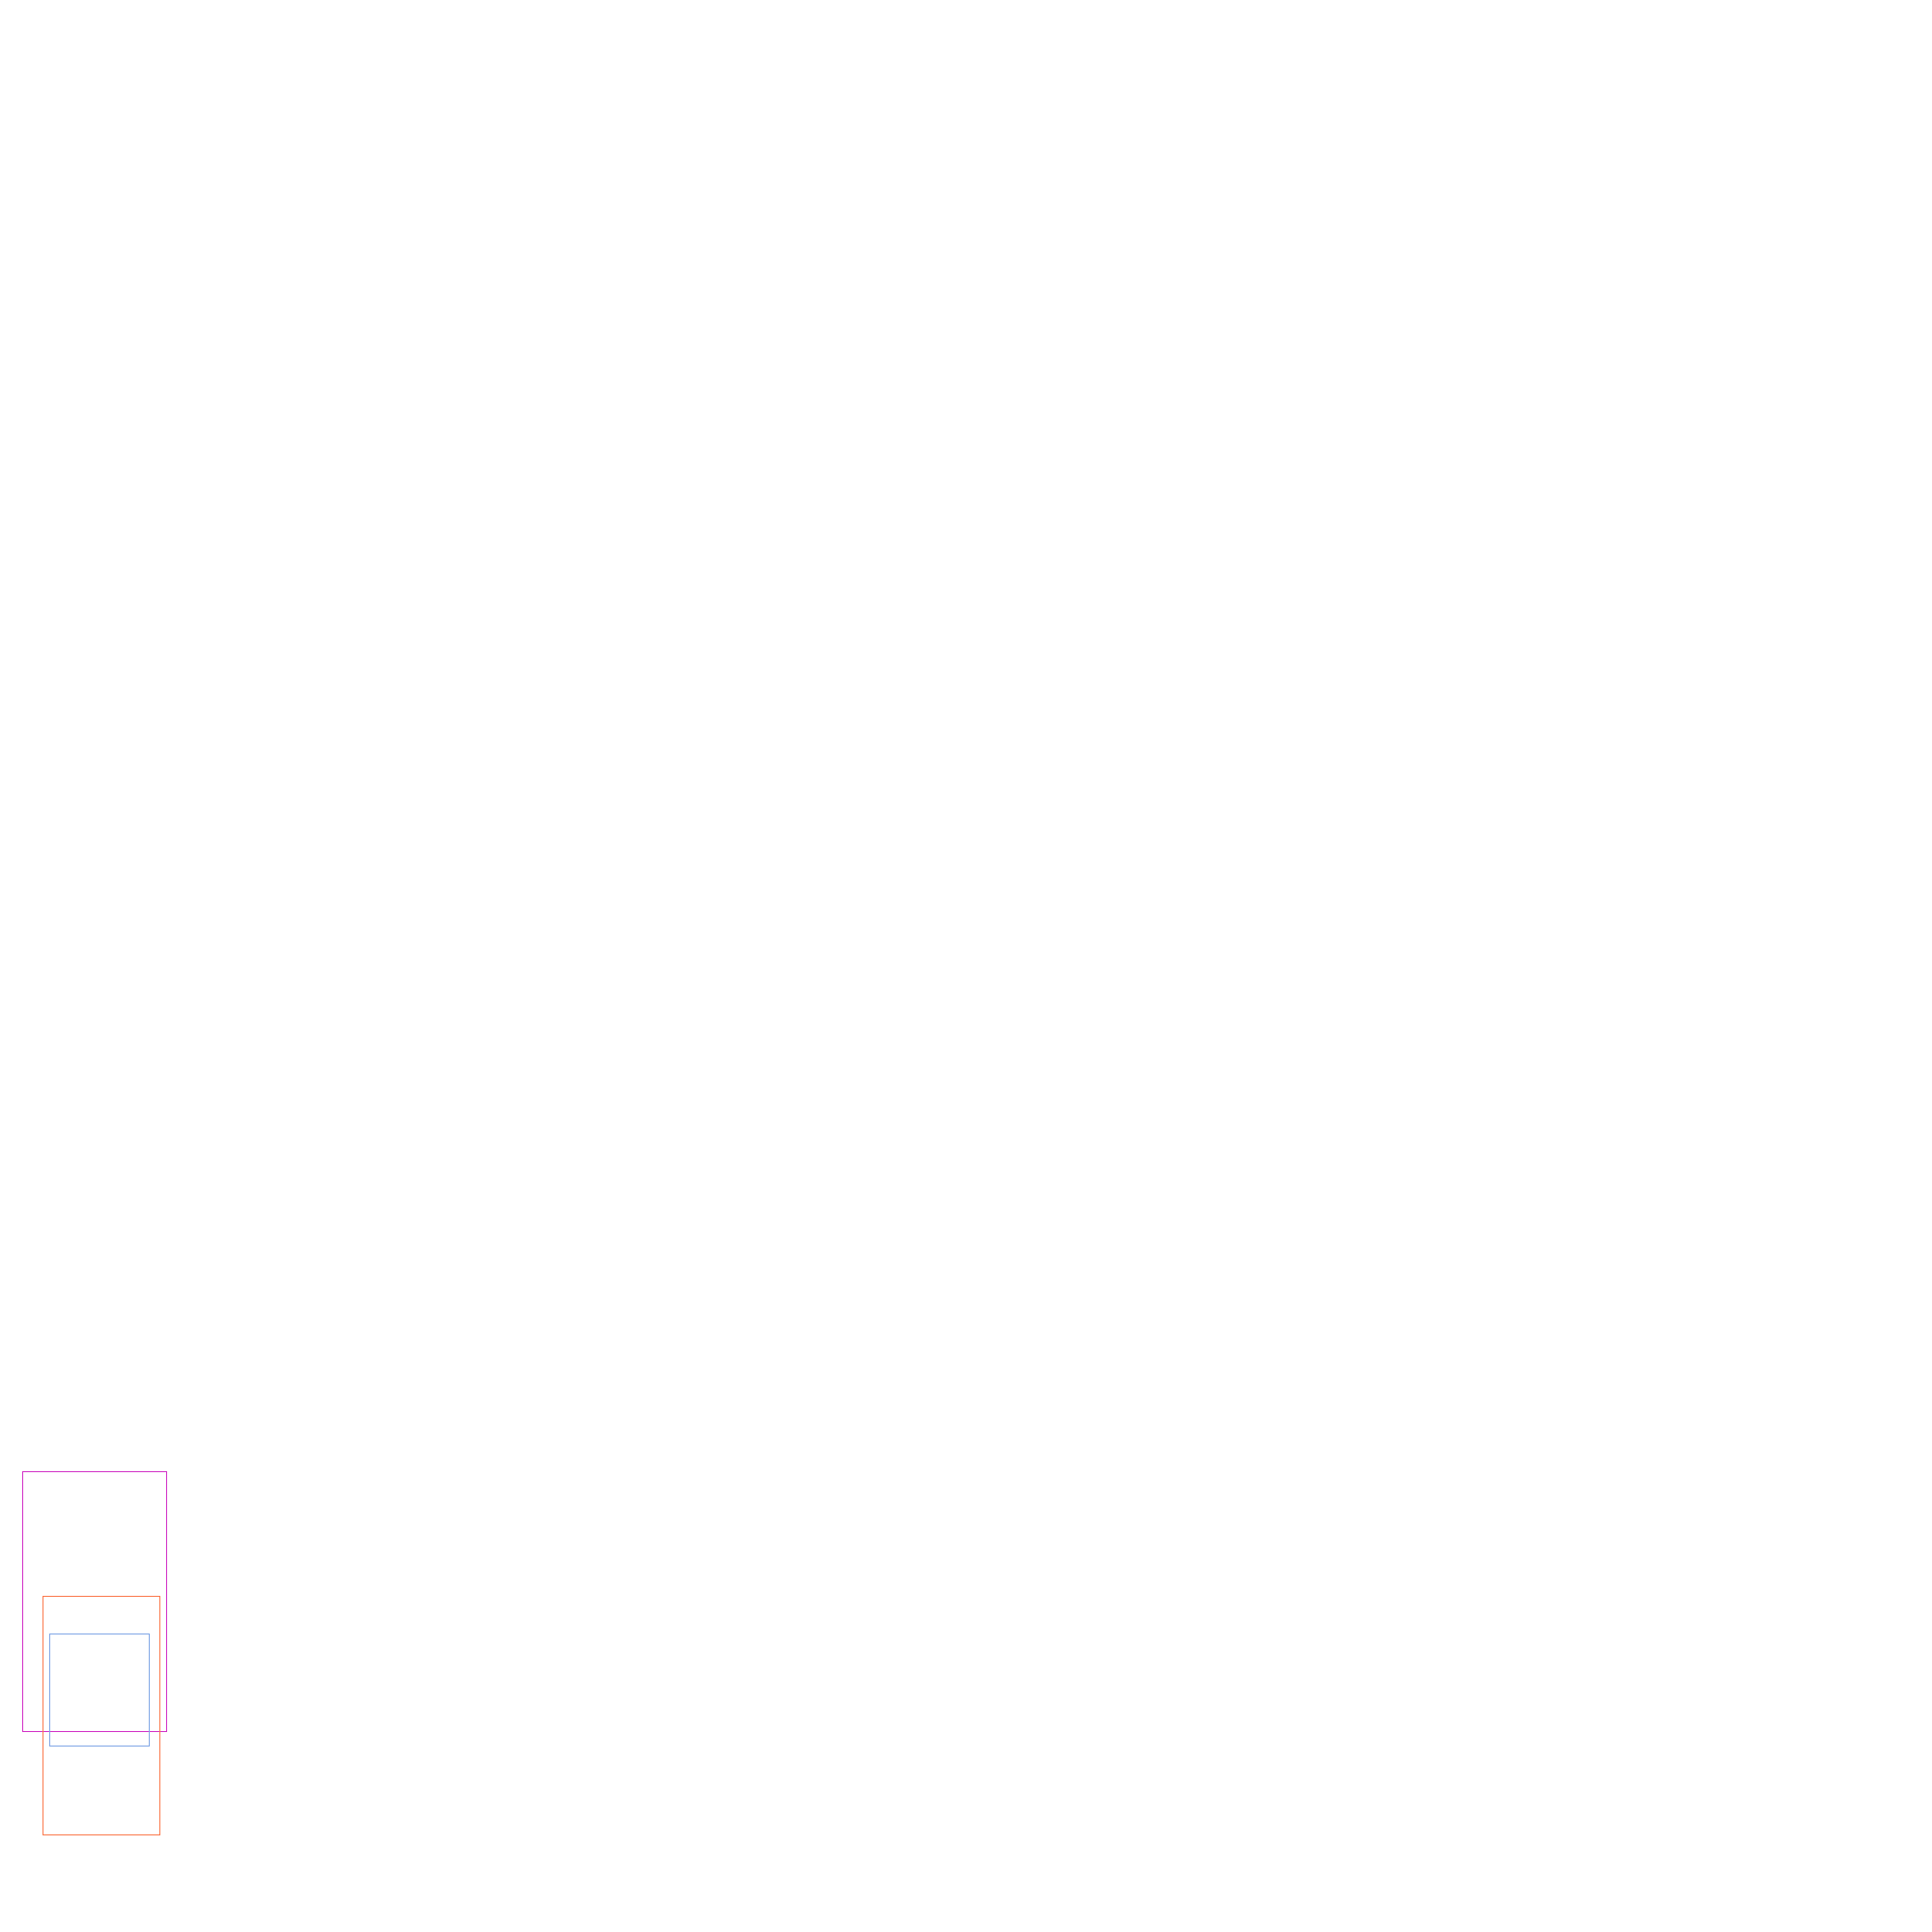

In [9]:
from PIL import Image
from src.visualization.visuialization_functions import hex_to_rgb

#Umwandlung in Pandas DataFrame, sollte hier aus Effizienzsicht nicht schlimm sein, da es nur wenige Mods gibt
#pandasMods = only_needed_columns.toPandas()
canvas = Image.new("RGB", (2000,2000), '#ffffff')

#Schrittweise Pixel im Canvas setzen
for index, row in pandasM.iterrows():
    canvas.putpixel((row['x'],row['y']), hex_to_rgb(row['pixel_color']))

canvas.show()
canvas.save('../reports/figures/mods-censors-canvas.jpg')